In [240]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm
from ipdb import set_trace as bp
from numba.typed import List

from collections import namedtuple

np.set_printoptions(linewidth=160, precision=2)

In [241]:
ParamTuple = namedtuple("ParamTuple", ["gamma", "p"])

In [242]:
# @jit(nopython=True)
def value_iteration_with_policy(
    R: np.ndarray,
    T_agent: np.ndarray,
    gamma: float,
    tol: float = 1e-6,
):
    n_states = R.shape[0]
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=np.int32)
    while True:
        V_new = np.zeros(n_states)
        for s in range(n_states):
            action_values = R[s] + gamma * np.sum(T_agent[s] * V, axis=1)
            best_action = np.argmax(action_values)
            V_new[s] = action_values[best_action]
            policy[s] = best_action
        if np.max(np.abs(V - V_new)) < tol:
            break
        V = V_new
    V = V / np.max(V) * R.max()
    return V, policy

In [243]:
# @jit(nopython=True)
def generate_trajectory(T_true, policy, absorbing_states, start_state=0, max_steps=100):
    trajectory = []
    current_state = start_state
    n_states = len(policy)

    while len(trajectory) < max_steps:
        if current_state in absorbing_states:
            trajectory.append((current_state, -1, -1))  # Append the absorbing state
            break
        chosen_action = policy[current_state]
        # Manually sample next_state based on T_true
        cumulative_prob = 0.0
        rand_num = np.random.rand()
        next_state = 0
        for s in range(n_states):
            cumulative_prob += T_true[current_state, chosen_action, s]
            if rand_num < cumulative_prob:
                next_state = s
                break

        trajectory.append((current_state, chosen_action, next_state))
        current_state = next_state

    trajectory = np.array(trajectory)
    return trajectory

In [244]:
# @jit(nopython=True)
def generate_n_trajectories(
    T_true, policy, absorbing_states, n_trajectories=100, max_steps=100
):
    trajectories = list()
    for _ in range(n_trajectories):
        trajectories.append(
            generate_trajectory(T_true, policy, absorbing_states, max_steps=max_steps)
        )
    return trajectories

In [245]:
# @jit(nopython=True)
def make_absorbing(R: np.ndarray, T: np.ndarray) -> None:
    reward_indices = np.where(R > 0)[0]
    T[reward_indices, :, :] = 0
    T[reward_indices, :, reward_indices] = 1

In [246]:
@jit(nopython=True)
def transition_matrix(N, M, p):
    n_states = N * M
    n_actions = 4  # N, E, S, W

    # Initialize the transition matrix
    T = np.zeros((n_states, n_actions, n_states))

    # Helper function to convert 2D grid indices to 1D state index
    to_s = lambda i, j: i * M + j

    # Populate the transition matrix
    for i in range(N):
        for j in range(M):
            s = to_s(i, j)

            # Neighboring states
            neighbors = {
                "N": to_s(i - 1, j) if i > 0 else s,
                "E": to_s(i, j + 1) if j < M - 1 else s,
                "S": to_s(i + 1, j) if i < N - 1 else s,
                "W": to_s(i, j - 1) if j > 0 else s,
            }

            # Set transition probabilities
            for a, action in enumerate(["N", "E", "S", "W"]):
                T[s, a, neighbors[action]] = p
                for other_action in set(["N", "E", "S", "W"]) - {action}:
                    T[s, a, neighbors[other_action]] += (1 - p) / 3

    return T

In [247]:
def plot_trajectories(N, M, trajectories, reward_matrix):
    plt.figure(figsize=(M, N))

    # Plot rewards as heatmap
    plt.imshow(reward_matrix.reshape(N, M), cmap="viridis", origin="upper")

    # Plot trajectories
    for traj in trajectories:
        x_coords, y_coords = [], []
        for s, _, _ in traj:
            x, y = divmod(s, M)
            x_coords.append(x)
            y_coords.append(y)

        # Plot the trajectories with a color that stands out
        plt.plot(y_coords, x_coords, marker="o", color="white", alpha=0.5)

    plt.colorbar(label="Reward")
    plt.gca().xaxis.tick_top()
    plt.show()

In [248]:
def plot_value_and_policy(
    value_function, policy, grid_shape, absorbing_states, title="", ax=None
):
    if ax is None:
        fig, ax = plt.subplots(figsize=grid_shape[::-1])

    ax.imshow(
        value_function.reshape(grid_shape),
        cmap="viridis",
        origin="upper",
        interpolation="nearest",
    )
    # Make colorbar
    cbar = ax.figure.colorbar(ax.get_images()[0])

    for s, val in enumerate(value_function):
        if s in absorbing_states:
            continue  # Skip arrows for absorbing states

        row, col = divmod(s, grid_shape[1])
        action = policy[s]
        if action == 0:  # N
            dx, dy = 0, -0.4
        elif action == 1:  # E
            dx, dy = 0.4, 0
        elif action == 2:  # S
            dx, dy = 0, 0.4
        elif action == 3:  # W
            dx, dy = -0.4, 0
        # make arrow
        ax.arrow(col, row, dx, dy, head_width=0.1, head_length=0.1, fc="r", ec="r")

    ax.set_title(title)

In [249]:
# Make function that counts state visit frequencies from trajectories
@jit(nopython=True)
def count_state_visits(trajectories, n_states):
    state_visits = np.zeros(n_states)
    for traj in trajectories:
        for s, _, _ in traj:
            state_visits[s] += 1
    return state_visits / state_visits.sum()

### Define a world where different $\gamma$ leads to different optimal policies


In [250]:
# World definition

# Key: S: start, Number: Reward size

# Idea: Make a reaaaaaaaaally simple BigSmall world to see if the
# likelihood calculation we have give reasonable numbers

#   0 1 2
# 0 S . .
# 1 . . .
# 2 1 . 4

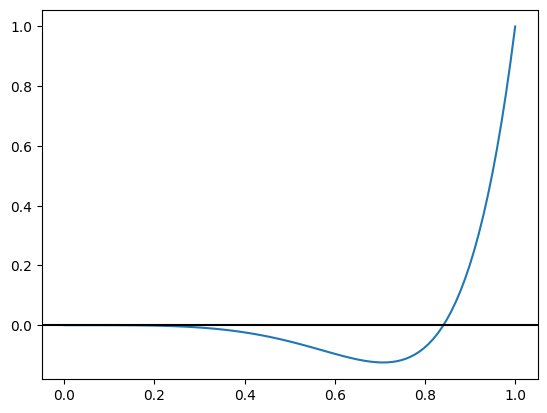

In [299]:
short_len = 4
long_len = 8
small_reward = 1

# Set big_reward such that the crossover for \gamma is at 0.75 (p = 1 for now)
big_reward = 2

xs = np.linspace(0, 1, 100)

plt.plot(xs, big_reward * xs**long_len - small_reward * xs**short_len)
plt.axhline(0, color="k")

In [252]:
N, M = 3, 3  # dimensions of the gridworld

n_states, n_actions = N * M, 4
R = np.array(
    [
        [0] * M,
        [0] * M,
        [small_reward, 0, big_reward],
    ]
).flatten()

true_params = ParamTuple(gamma=0.5, p=0.9)

T_agent_ground = transition_matrix(N, M, p=true_params.p)  # Agent's transition matrix
T_true = transition_matrix(N, M, p=0.9)  # True transition matrix
absorbing_states = np.where(R > 0)[0]  # Absorbing states

make_absorbing(R, T_agent_ground)
make_absorbing(R, T_true)

In [253]:
# Generate V and policy
V_ground, ground_policy = value_iteration_with_policy(
    R, T_agent_ground, gamma=true_params.gamma
)
non_absorbing_states = np.where(R <= 0)[0]
ground_policy[non_absorbing_states]

array([2, 2, 2, 2, 2, 2, 1], dtype=int32)

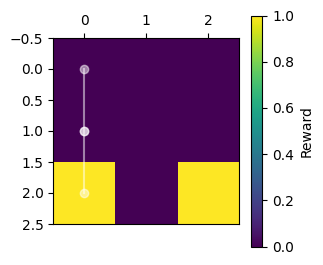

In [254]:
# Generate trajectories
trajectories = generate_n_trajectories(
    T_true, ground_policy, absorbing_states, n_trajectories=1, max_steps=100
)

plot_trajectories(N, M, trajectories, R)

In [256]:
len(trajectories)

1

## Make the simplest possible case

We have two parameter samples from the posterior: $\{\gamma_1=0.5, \gamma_2 = 0.9\}$.

The first will produce a trajectory going down, the second will produce a trajectory going right.

Then, we can get the likelihood for each of these trajectories under their own $\gamma$.

Then, we can find one policy that tries to maximize the likelihood of the dataset $\mathcal D$ consisting of these two trajectories.

Hopefully (_dear god_) this will be smaller than the likelihood of the dataset $\mathcal D$ under the true $\gamma$-s.


In [257]:
def det_to_prob_pol(policy, smoothing=0.0):
    policy = np.eye(n_actions)[policy]
    policy += smoothing
    policy /= policy.sum(axis=1, keepdims=True)
    return policy

In [258]:
posterior1 = 0.5
posterior2 = 0.9

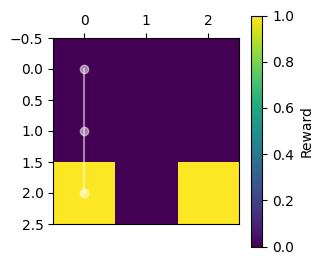

In [259]:
# Make trajectory for posterior1
_, policy1 = value_iteration_with_policy(R, T_agent_ground, gamma=posterior1)

# Generate trajectories
trajectories1 = generate_n_trajectories(
    T_true, policy1, absorbing_states, n_trajectories=1, max_steps=100
)

policy1 = det_to_prob_pol(policy1, smoothing=0.0)

plot_trajectories(N, M, trajectories1, R)

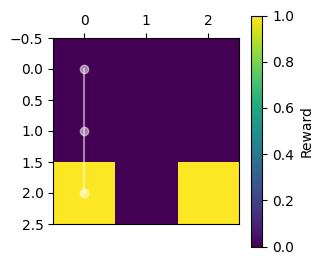

In [276]:
# Make trajectory for posterior2
_, policy2 = value_iteration_with_policy(R, T_agent_ground, gamma=posterior2)

# Generate trajectories
trajectories2 = generate_n_trajectories(
    T_true, policy2, absorbing_states, n_trajectories=1, max_steps=100
)

policy2 = det_to_prob_pol(policy2, smoothing=0.0)

plot_trajectories(N, M, trajectories2, R)

In [277]:
policies = [policy1, policy2]

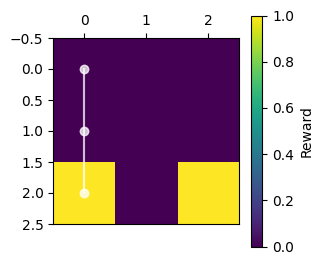

In [278]:
trajectories = trajectories1 + trajectories2

plot_trajectories(N, M, trajectories, R)

In [279]:
# Make function to calculate log-likelihood of a trajectory given a transition matrix and policy
def log_likelihood(T, policy, trajectory):
    log_likelihood = 0.0
    for s, a, next_s in trajectory[:-1]:
        log_likelihood += np.log(T[s, a, next_s] * policy[s, a])
    return log_likelihood

In [280]:
cand_pol = np.ones((n_states, n_actions)) / n_actions

In [281]:
(
    log_likelihood(T_true, policies[0], trajectories[0]),
    log_likelihood(T_true, cand_pol, trajectories[0]),
    log_likelihood(T_true, policies[1], trajectories[1]),
    log_likelihood(T_true, cand_pol, trajectories[1]),
)

(-0.21072103131565256,
 -2.983309753555434,
 -0.21072103131565256,
 -2.983309753555434)

In [282]:
(
    (
        log_likelihood(T_true, policies[0], trajectories[0])
        + log_likelihood(T_true, policies[1], trajectories[1])
    )
    / 2,
    (
        log_likelihood(T_true, cand_pol, trajectories[0])
        + log_likelihood(T_true, cand_pol, trajectories[1])
    )
    / 2,
)

(-0.21072103131565256, -2.983309753555434)

In [283]:
from tqdm import trange

best = -np.inf
best_pol = None
best_list = []

100%|██████████| 5000000/5000000 [01:01<00:00, 81399.62it/s]


(-0.3288827679935827,
 array([[2.64e-02, 1.61e-02, 9.57e-01, 8.56e-04],
        [7.64e-03, 4.98e-01, 1.58e-01, 3.36e-01],
        [5.09e-01, 8.44e-02, 1.50e-01, 2.57e-01],
        [5.11e-02, 1.11e-02, 9.29e-01, 9.05e-03],
        [3.50e-01, 3.77e-01, 7.37e-02, 1.99e-01],
        [1.30e-01, 9.36e-02, 5.10e-01, 2.66e-01],
        [3.97e-01, 3.97e-01, 4.13e-02, 1.64e-01],
        [3.10e-01, 3.43e-01, 1.02e-01, 2.45e-01],
        [7.24e-02, 1.58e-01, 7.20e-01, 4.99e-02]]))

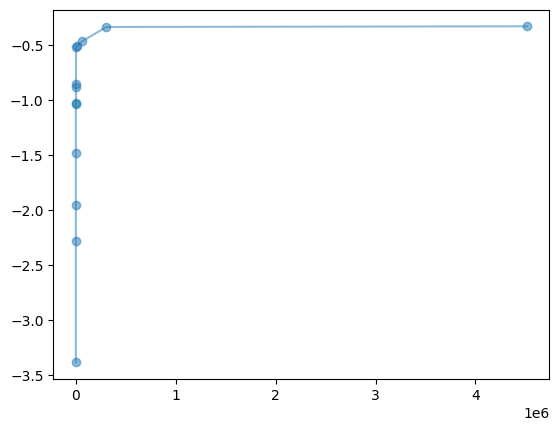

In [284]:
for i in trange(5_000_000):
    # Sample a new policy
    cand_pol = np.random.dirichlet(np.ones(n_actions), size=n_states)

    mean_log_likelihood = np.array(
        [log_likelihood(T_true, cand_pol, traj) for traj in trajectories]
    ).mean()

    if mean_log_likelihood > best:
        best = mean_log_likelihood
        best_pol = cand_pol
        best_list.append((i, best))


# Plot the best list with circles
plt.plot([x[0] for x in best_list], [x[1] for x in best_list], "-o", alpha=0.5)

best, best_pol

## Put it all together to a more comprehensive example


In [303]:
def run_likelihood_exp(big_reward, N=3, M=3):
    small_reward = 1
    n_states, n_actions = N * M, 4
    R = np.zeros((N, M))

    R[-1, 0] = small_reward
    R[-1, -1] = big_reward

    R = R.flatten()

    T_true = transition_matrix(N, M, p=0.9)  # True transition matrix
    absorbing_states = np.where(R > 0)[0]  # Absorbing states
    make_absorbing(R, T_true)

    posterior1 = 0.5
    posterior2 = 0.9

    # Make trajectory for posterior1
    _, policy1 = value_iteration_with_policy(R, T_agent_ground, gamma=posterior1)

    # Generate trajectories
    trajectories1 = generate_n_trajectories(
        T_true, policy1, absorbing_states, n_trajectories=1, max_steps=100
    )

    policy1 = det_to_prob_pol(policy1, smoothing=0.0)

    # Make trajectory for posterior2
    _, policy2 = value_iteration_with_policy(R, T_agent_ground, gamma=posterior2)

    # Generate trajectories
    trajectories2 = generate_n_trajectories(
        T_true, policy2, absorbing_states, n_trajectories=1, max_steps=100
    )

    policy2 = det_to_prob_pol(policy2, smoothing=0.0)

    policies = [policy1, policy2]
    trajectories = trajectories1 + trajectories2

    plot_trajectories(N, M, trajectories, R)

    mean_likelihood_star = (
        log_likelihood(T_true, policies[0], trajectories[0])
        + log_likelihood(T_true, policies[1], trajectories[1])
    ) / 2

    print(f"Mean likelihood star: {mean_likelihood_star}")

    best = -np.inf
    best_pol = None
    best_list = []
    for i in trange(1_000_000):
        # Sample a new policy
        cand_pol = np.random.dirichlet(np.ones(n_actions), size=n_states)

        mean_log_likelihood = np.array(
            [log_likelihood(T_true, cand_pol, traj) for traj in trajectories]
        ).mean()

        if mean_log_likelihood > best:
            best = mean_log_likelihood
            best_pol = cand_pol
            best_list.append((i, best))

    # Plot the best list with circles
    # plt.plot([x[0] for x in best_list], [x[1] for x in best_list], "-o", alpha=0.5)

    print(f"Best likelihood: {best}")

    return mean_likelihood_star, best

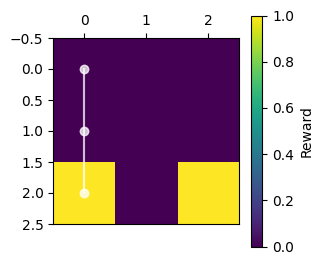

Mean likelihood star: -0.21072103131565256


100%|██████████| 1000000/1000000 [00:12<00:00, 79259.59it/s]


Best likelihood: -0.35941928045773186


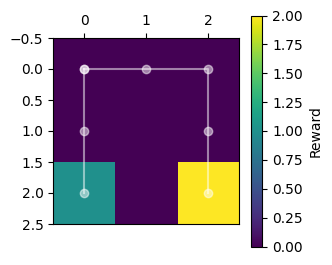

Mean likelihood star: -0.31608154697347884


100%|██████████| 1000000/1000000 [00:14<00:00, 66876.44it/s]


Best likelihood: -1.875746369440737


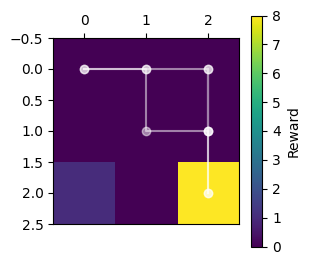

Mean likelihood star: -2.1747210112912962


100%|██████████| 1000000/1000000 [00:19<00:00, 52100.89it/s]

Best likelihood: -4.254028934336832


In [304]:
results1 = (
    run_likelihood_exp(big_reward=1),
    run_likelihood_exp(big_reward=2),
    run_likelihood_exp(big_reward=8),
)

In [310]:
with np.printoptions(precision=2, suppress=True):
    print(-np.diff(np.exp(np.array(results1))).flatten())

[0.11 0.58 0.1 ]
